# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 2 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

global threshold_low1, threshold_high1, threshold_low2, threshold_high2
threshold_low1 = 0 #300 works
threshold_high1 = 60
threshold_low2 = 500 #300 works
threshold_high2 = 2000

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5+(((x+5)*(5--5))/(51+5)))
def ynew(y): 
    return (-5+(((y+2)*(5--5))/(53+2)))

def hblau(x):
       
#     return ((1.5-(x[0])+(x[0]*x[1]))**2)+ ((2.25-(x[0])+(x[0]*(x[1]**2)))**2)+ ((2.625-(x[0])+(x[0]*(x[1]**3)))**2)
    return ((((x[0]**2)+(x[1])-11)**2)+(((x[0])+((x[1])**2)-7)**2))

def hblauColor(x, threshold_low1, threshold_high1, threshold_low2, threshold_high2):
    
    if (threshold_low1<hblau((xnew(x[0]),xnew(x[1])))<threshold_high1)|(threshold_low2<hblau((xnew(x[0]),xnew(x[1])))<threshold_high2):
        return 1
    else:
        return 0
      

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zhblau
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .2  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zhblau = []
    hblaucoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(77000):
        Zhblau.append(hblauColor(hblaucoords[i],threshold_low1,threshold_high1,threshold_low2,threshold_high2))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zhblau)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(77000):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


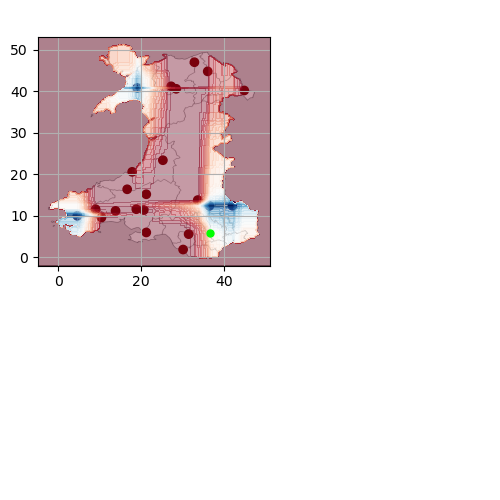

iteration  1
Accuracy is 0.7836192584394023
iteration  2
Accuracy is 0.7980692369181578
iteration  3
Accuracy is 0.7814056447149972
iteration  4
Accuracy is 0.6225788599889319
iteration  5
Accuracy is 0.6454528684744512
iteration  6
Accuracy is 0.7148127651724774
iteration  7
Accuracy is 0.7752259730676997
iteration  8
Accuracy is 0.7402078337330136
iteration  9
Accuracy is 0.7732275717887229
iteration  10
Accuracy is 0.7204697780237349
iteration  11
Accuracy is 0.7561335546947058
iteration  12
Accuracy is 0.7544425997663408
iteration  13
Accuracy is 0.7837729816147082
iteration  14
Accuracy is 0.7852179794625838
iteration  15
Accuracy is 0.7846645760314825
iteration  16
Accuracy is 0.7638812027301236
iteration  17
Accuracy is 0.785586915083318
iteration  18
Accuracy is 0.7775010760622272
iteration  19
Accuracy is 0.7837729816147082
iteration  20
Accuracy is 0.7769784172661871
iteration  21
Accuracy is 0.777992990223206
experiment:  1


<IPython.core.display.Javascript object>


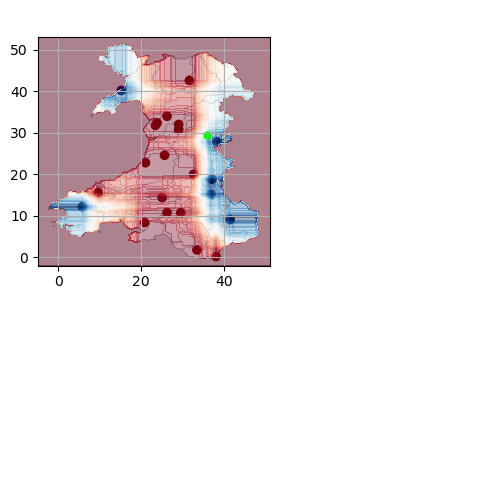

iteration  1
Accuracy is 0.6406874500399681
iteration  2
Accuracy is 0.7157965934944353
iteration  3
Accuracy is 0.7212691385353256
iteration  4
Accuracy is 0.7049129926827769
iteration  5
Accuracy is 0.719485949701777
iteration  6
Accuracy is 0.7241898788661378
iteration  7
Accuracy is 0.7383939002644039
iteration  8
Accuracy is 0.7590235503904569
iteration  9
Accuracy is 0.788138719793396
iteration  10
Accuracy is 0.77731660825186
iteration  11
Accuracy is 0.7870011682961323
iteration  12
Accuracy is 0.7933960523888581
iteration  13
Accuracy is 0.7523519645821805
iteration  14
Accuracy is 0.7670171555063642
iteration  15
Accuracy is 0.7615138658304126
iteration  16
Accuracy is 0.8003443399126853
iteration  17
Accuracy is 0.8316116337699071
iteration  18
Accuracy is 0.8268769599704852
iteration  19
Accuracy is 0.8333640779683945
iteration  20
Accuracy is 0.8364692861095738
iteration  21
Accuracy is 0.8479677796224558
experiment:  2


<IPython.core.display.Javascript object>


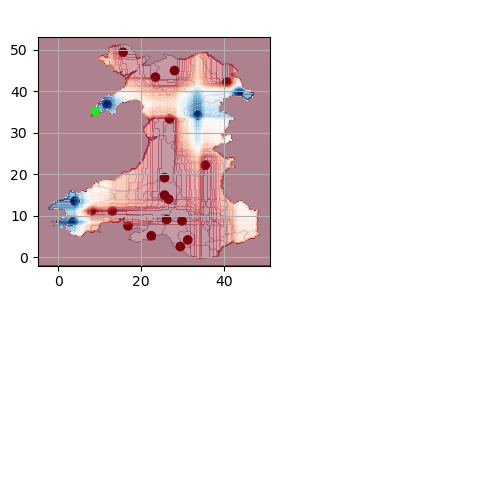

iteration  1
Accuracy is 0.39380803049867796
iteration  2
Accuracy is 0.6623624177581012
iteration  3
Accuracy is 0.5515587529976019
iteration  4
Accuracy is 0.5363709032773781
iteration  5
Accuracy is 0.528592510606899
iteration  6
Accuracy is 0.6629465658242637
iteration  7
Accuracy is 0.6857898296747218
iteration  8
Accuracy is 0.6899096107729201
iteration  9
Accuracy is 0.7187480784603086
iteration  10
Accuracy is 0.7170263788968825
iteration  11
Accuracy is 0.6917542888765911
iteration  12
Accuracy is 0.7217610526963045
iteration  13
Accuracy is 0.7094631986718317
iteration  14
Accuracy is 0.7364569882555494
iteration  15
Accuracy is 0.7072803295824879
iteration  16
Accuracy is 0.7751952284326386
iteration  17
Accuracy is 0.7753489516079444
iteration  18
Accuracy is 0.788138719793396
iteration  19
Accuracy is 0.7781467133985119
iteration  20
Accuracy is 0.8024349750968456
iteration  21
Accuracy is 0.7949640287769785
experiment:  3


<IPython.core.display.Javascript object>


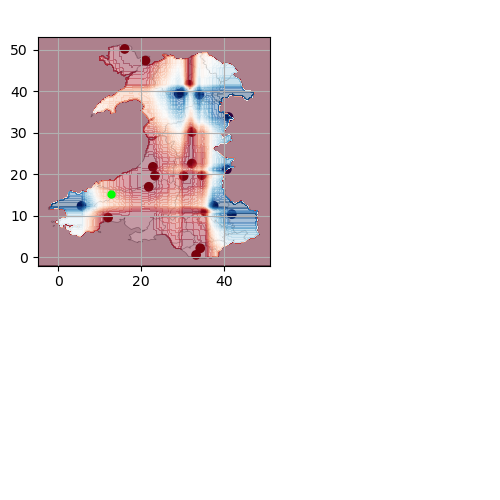

iteration  1
Accuracy is 0.585377851564902
iteration  2
Accuracy is 0.673491975650249
iteration  3
Accuracy is 0.6744143147020845
iteration  4
Accuracy is 0.7411916620549714
iteration  5
Accuracy is 0.6714628297362111
iteration  6
Accuracy is 0.5864231691569821
iteration  7
Accuracy is 0.664360819037078
iteration  8
Accuracy is 0.6236549222160733
iteration  9
Accuracy is 0.620734181885261
iteration  10
Accuracy is 0.6422861710631494
iteration  11
Accuracy is 0.5982905982905983
iteration  12
Accuracy is 0.6179364200946935
iteration  13
Accuracy is 0.653200516509869
iteration  14
Accuracy is 0.6309414007255734
iteration  15
Accuracy is 0.7141978724712538
iteration  16
Accuracy is 0.7569944044764189
iteration  17
Accuracy is 0.7660640718194675
iteration  18
Accuracy is 0.7969931746910164
iteration  19
Accuracy is 0.8071081596261452
iteration  20
Accuracy is 0.8214044149295948
iteration  21
Accuracy is 0.8243558998954682
experiment:  4


<IPython.core.display.Javascript object>


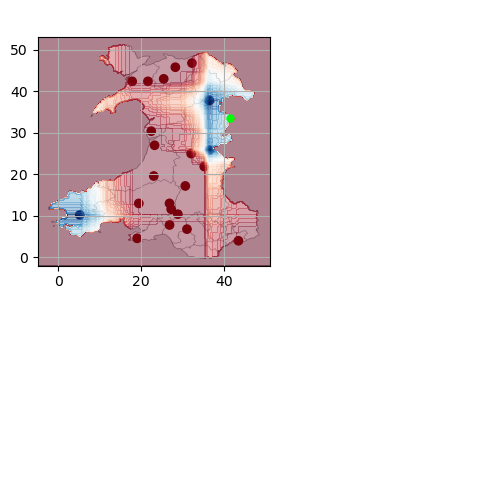

iteration  1
Accuracy is 0.5237963475373547
iteration  2
Accuracy is 0.6515710508516264
iteration  3
Accuracy is 0.6721699563426182
iteration  4
Accuracy is 0.6627006087437742
iteration  5
Accuracy is 0.7099551128328107
iteration  6
Accuracy is 0.7110926643300745
iteration  7
Accuracy is 0.7119842587468487
iteration  8
Accuracy is 0.7098628789276271
iteration  9
Accuracy is 0.7070036278669373
iteration  10
Accuracy is 0.7052511836684499
iteration  11
Accuracy is 0.7446965504519462
iteration  12
Accuracy is 0.7426059152677857
iteration  13
Accuracy is 0.7552112156428703
iteration  14
Accuracy is 0.7603763143331489
iteration  15
Accuracy is 0.7466949517309229
iteration  16
Accuracy is 0.7595769538215581
iteration  17
Accuracy is 0.7286478509500092
iteration  18
Accuracy is 0.7485088851995327
iteration  19
Accuracy is 0.7436819774949271
iteration  20
Accuracy is 0.7480477156736149
iteration  21
Accuracy is 0.7797454344216934
experiment:  5


<IPython.core.display.Javascript object>


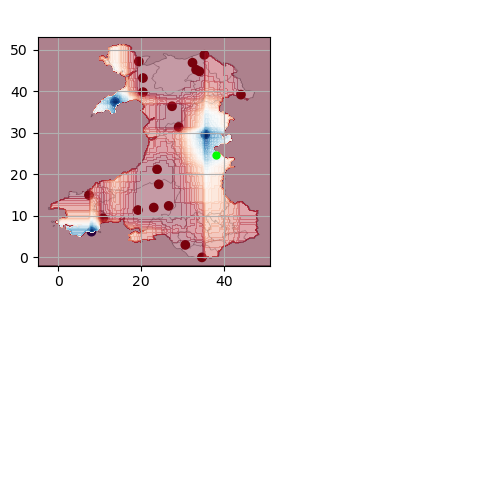

iteration  1
Accuracy is 0.32263420033204204
iteration  2
Accuracy is 0.3342249277501076
iteration  3
Accuracy is 0.6442538277070651
iteration  4
Accuracy is 0.6777654799237534
iteration  5
Accuracy is 0.6863739777408843
iteration  6
Accuracy is 0.6762589928057554
iteration  7
Accuracy is 0.6853594047838653
iteration  8
Accuracy is 0.6759208018200824
iteration  9
Accuracy is 0.6918157781467134
iteration  10
Accuracy is 0.70915575232122
iteration  11
Accuracy is 0.6595646559675337
iteration  12
Accuracy is 0.674844739592941
iteration  13
Accuracy is 0.6879726987640656
iteration  14
Accuracy is 0.7349505011375514
iteration  15
Accuracy is 0.7829428764680563
iteration  16
Accuracy is 0.7818975588759761
iteration  17
Accuracy is 0.7978232798376683
iteration  18
Accuracy is 0.783895960154953
iteration  19
Accuracy is 0.7753796962430056
iteration  20
Accuracy is 0.7792227756256533
iteration  21
Accuracy is 0.7703375760929718
experiment:  6


<IPython.core.display.Javascript object>


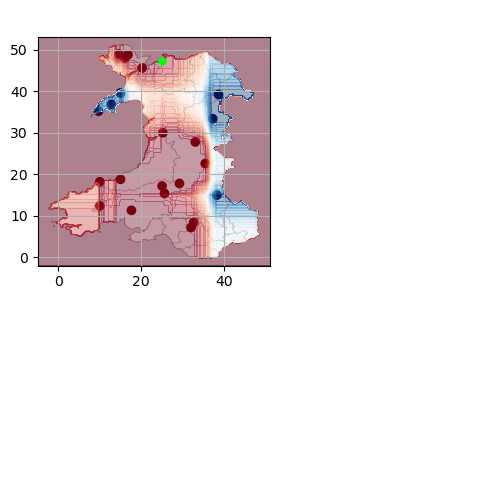

iteration  1
Accuracy is 0.6995019369120089
iteration  2
Accuracy is 0.6975342802680932
iteration  3
Accuracy is 0.7136444690401524
iteration  4
Accuracy is 0.6719854885322512
iteration  5
Accuracy is 0.7600073787124146
iteration  6
Accuracy is 0.762098013896575
iteration  7
Accuracy is 0.801666359220316
iteration  8
Accuracy is 0.7971468978663223
iteration  9
Accuracy is 0.8044333763758225
iteration  10
Accuracy is 0.832933653077538
iteration  11
Accuracy is 0.8414806616245465
iteration  12
Accuracy is 0.8365615200147575
iteration  13
Accuracy is 0.8497202238209433
iteration  14
Accuracy is 0.8148865522966242
iteration  15
Accuracy is 0.8522412838959601
iteration  16
Accuracy is 0.836991944905614
iteration  17
Accuracy is 0.8581442538277071
iteration  18
Accuracy is 0.8478448010822112
iteration  19
Accuracy is 0.8336407796839451
iteration  20
Accuracy is 0.8339174813994958
iteration  21
Accuracy is 0.8363770522043903
experiment:  7


<IPython.core.display.Javascript object>


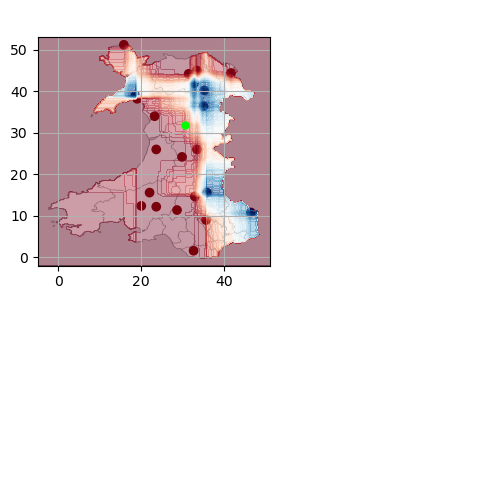

iteration  1
Accuracy is 0.8055709278730862
iteration  2
Accuracy is 0.699686404722376
iteration  3
Accuracy is 0.7708294902539506
iteration  4
Accuracy is 0.7664022628051405
iteration  5
Accuracy is 0.7568406813011129
iteration  6
Accuracy is 0.7789768185451639
iteration  7
Accuracy is 0.85171862509992
iteration  8
Accuracy is 0.8350242882616984
iteration  9
Accuracy is 0.822449732521675
iteration  10
Accuracy is 0.8146405952161347
iteration  11
Accuracy is 0.8140871917850335
iteration  12
Accuracy is 0.8220500522658796
iteration  13
Accuracy is 0.802496464366968
iteration  14
Accuracy is 0.811289429994466
iteration  15
Accuracy is 0.8100903892270799
iteration  16
Accuracy is 0.8200516509869028
iteration  17
Accuracy is 0.8291213183299514
iteration  18
Accuracy is 0.8217426059152678
iteration  19
Accuracy is 0.8313349320543565
iteration  20
Accuracy is 0.8337330135891287
iteration  21
Accuracy is 0.8489208633093526
experiment:  8


<IPython.core.display.Javascript object>


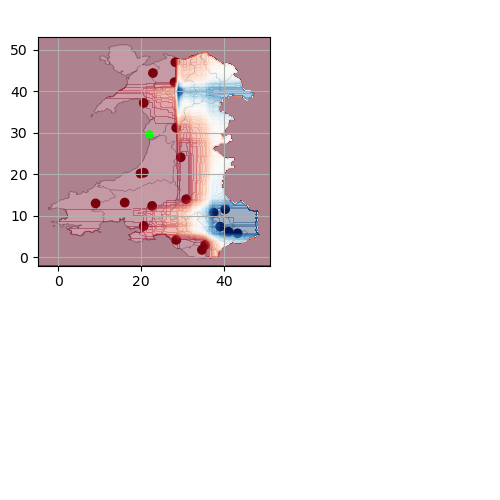

iteration  1
Accuracy is 0.732490930332657
iteration  2
Accuracy is 0.6043472913976511
iteration  3
Accuracy is 0.6155383385599212
iteration  4
Accuracy is 0.6678657074340527
iteration  5
Accuracy is 0.645914038000369
iteration  6
Accuracy is 0.6877574863186374
iteration  7
Accuracy is 0.7456188895037816
iteration  8
Accuracy is 0.7557031298038492
iteration  9
Accuracy is 0.750599520383693
iteration  10
Accuracy is 0.7468486749062289
iteration  11
Accuracy is 0.7609604623993114
iteration  12
Accuracy is 0.753796962430056
iteration  13
Accuracy is 0.6538461538461539
iteration  14
Accuracy is 0.6898173768677366
iteration  15
Accuracy is 0.802004550205989
iteration  16
Accuracy is 0.791858820635799
iteration  17
Accuracy is 0.8380065178626329
iteration  18
Accuracy is 0.8095677304310398
iteration  19
Accuracy is 0.7906905245034741
iteration  20
Accuracy is 0.8143024042304617
iteration  21
Accuracy is 0.8140257025149111
experiment:  9


<IPython.core.display.Javascript object>


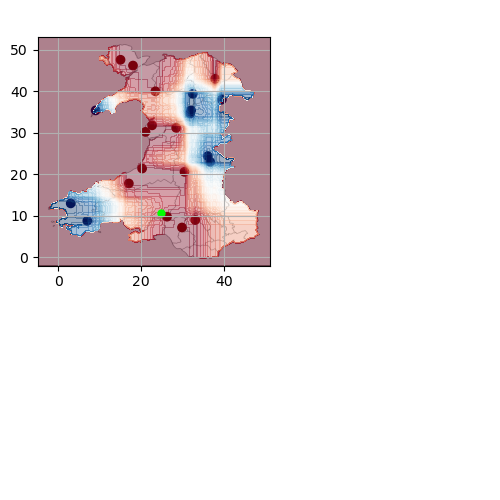

iteration  1
Accuracy is 0.6544917911824386
iteration  2
Accuracy is 0.5309598475066101
iteration  3
Accuracy is 0.4183422492775011
iteration  4
Accuracy is 0.3485826723236795
iteration  5
Accuracy is 0.3286294041689725
iteration  6
Accuracy is 0.34744512082641577
iteration  7
Accuracy is 0.42768861833610033
iteration  8
Accuracy is 0.5606899096107729
iteration  9
Accuracy is 0.6797638812027301
iteration  10
Accuracy is 0.7100780913730554
iteration  11
Accuracy is 0.730984443214659
iteration  12
Accuracy is 0.7496464366967964
iteration  13
Accuracy is 0.7261575355100535
iteration  14
Accuracy is 0.7426674045379081
iteration  15
Accuracy is 0.7562565332349505
iteration  16
Accuracy is 0.7652339666728156
iteration  17
Accuracy is 0.7982537047285249
iteration  18
Accuracy is 0.8029268892578245
iteration  19
Accuracy is 0.7850335116522167
iteration  20
Accuracy is 0.823310582303388
iteration  21
Accuracy is 0.8179917604378036
experiment:  10


<IPython.core.display.Javascript object>


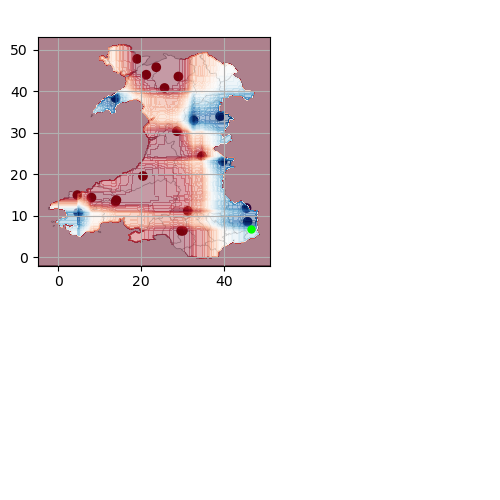

iteration  1
Accuracy is 0.5412285556170449
iteration  2
Accuracy is 0.655906044395253
iteration  3
Accuracy is 0.7048515034126545
iteration  4
Accuracy is 0.6660825186005042
iteration  5
Accuracy is 0.7460493143946382
iteration  6
Accuracy is 0.8347168419110865
iteration  7
Accuracy is 0.8351780114370042
iteration  8
Accuracy is 0.8651847752567177
iteration  9
Accuracy is 0.8403431101272828
iteration  10
Accuracy is 0.8478448010822112
iteration  11
Accuracy is 0.8157781467133985
iteration  12
Accuracy is 0.8609420156182747
iteration  13
Accuracy is 0.8558691508331796
iteration  14
Accuracy is 0.8784049683330258
iteration  15
Accuracy is 0.8992805755395683
iteration  16
Accuracy is 0.8984197257578552
iteration  17
Accuracy is 0.8879050605669311
iteration  18
Accuracy is 0.8960216442230831
iteration  19
Accuracy is 0.8920555863001907
iteration  20
Accuracy is 0.8989731291889566
iteration  21
Accuracy is 0.8998647236057308
experiment:  11


<IPython.core.display.Javascript object>


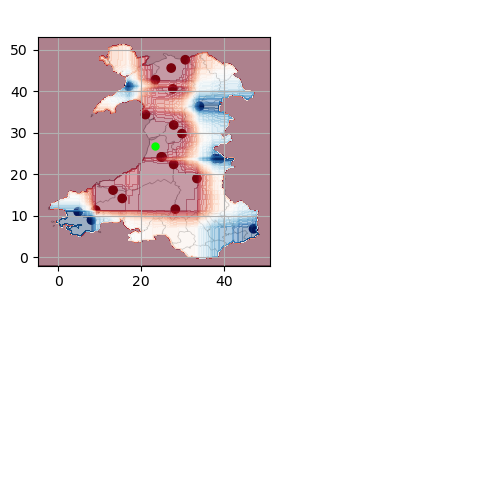

iteration  1
Accuracy is 0.7024534218778823
iteration  2
Accuracy is 0.6930455635491607
iteration  3
Accuracy is 0.5609051220562012
iteration  4
Accuracy is 0.6586423169156982
iteration  5
Accuracy is 0.6884338682899834
iteration  6
Accuracy is 0.6590727418065547
iteration  7
Accuracy is 0.6120334501629465
iteration  8
Accuracy is 0.637121072372871
iteration  9
Accuracy is 0.6484965873455082
iteration  10
Accuracy is 0.6395498985427043
iteration  11
Accuracy is 0.6955358789891164
iteration  12
Accuracy is 0.6824079198179918
iteration  13
Accuracy is 0.7771628850765542
iteration  14
Accuracy is 0.7631125868535941
iteration  15
Accuracy is 0.7818975588759761
iteration  16
Accuracy is 0.8164852733198057
iteration  17
Accuracy is 0.7908135030437189
iteration  18
Accuracy is 0.8512267109389412
iteration  19
Accuracy is 0.8398204513312427
iteration  20
Accuracy is 0.8027731660825186
iteration  21
Accuracy is 0.8319498247555801
experiment:  12


<IPython.core.display.Javascript object>


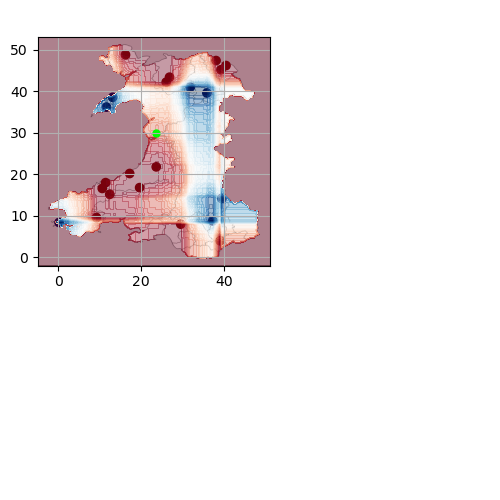

iteration  1
Accuracy is 0.5310828260468549
iteration  2
Accuracy is 0.656582426366599
iteration  3
Accuracy is 0.603148250630265
iteration  4
Accuracy is 0.6899711000430425
iteration  5
Accuracy is 0.706634692246203
iteration  6
Accuracy is 0.7049129926827769
iteration  7
Accuracy is 0.707649265203222
iteration  8
Accuracy is 0.7092787308614646
iteration  9
Accuracy is 0.716104039845047
iteration  10
Accuracy is 0.715765848859374
iteration  11
Accuracy is 0.7129373424337453
iteration  12
Accuracy is 0.7347352886921232
iteration  13
Accuracy is 0.7573325954620919
iteration  14
Accuracy is 0.7677242821127713
iteration  15
Accuracy is 0.8563303203590973
iteration  16
Accuracy is 0.8393285371702638
iteration  17
Accuracy is 0.8293365307753797
iteration  18
Accuracy is 0.8063702883846768
iteration  19
Accuracy is 0.8189755887597614
iteration  20
Accuracy is 0.8598966980261944
iteration  21
Accuracy is 0.8297669556662363
experiment:  13


<IPython.core.display.Javascript object>


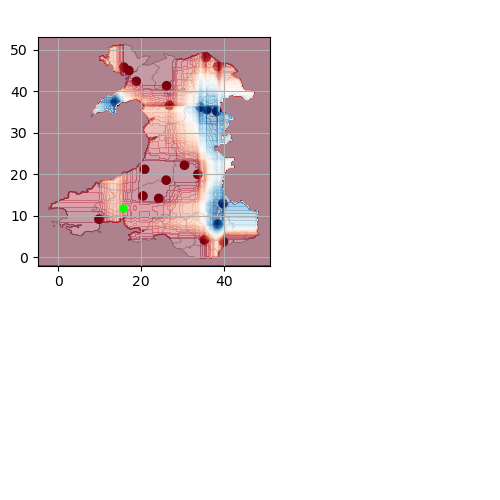

iteration  1
Accuracy is 0.7012236364754351
iteration  2
Accuracy is 0.7095554325770154
iteration  3
Accuracy is 0.710016602102933
iteration  4
Accuracy is 0.7988685974297485
iteration  5
Accuracy is 0.7889995695751092
iteration  6
Accuracy is 0.8309967410686835
iteration  7
Accuracy is 0.8295517432208079
iteration  8
Accuracy is 0.8215888827399619
iteration  9
Accuracy is 0.8189755887597614
iteration  10
Accuracy is 0.8202053741622087
iteration  11
Accuracy is 0.8210662239439218
iteration  12
Accuracy is 0.8387751337391626
iteration  13
Accuracy is 0.8431101272827891
iteration  14
Accuracy is 0.8276148312119536
iteration  15
Accuracy is 0.8390210908196519
iteration  16
Accuracy is 0.841234704544057
iteration  17
Accuracy is 0.8388673676443461
iteration  18
Accuracy is 0.8125499600319744
iteration  19
Accuracy is 0.8318268462153354
iteration  20
Accuracy is 0.8516263911947365
iteration  21
Accuracy is 0.8827092172415913
experiment:  14


<IPython.core.display.Javascript object>


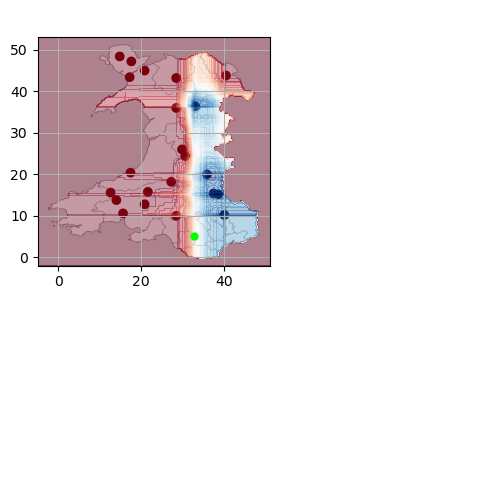

iteration  1
Accuracy is 0.5467011006579352
iteration  2
Accuracy is 0.6799483490130972
iteration  3
Accuracy is 0.7355346492037139
iteration  4
Accuracy is 0.7460185697595769
iteration  5
Accuracy is 0.7212691385353256
iteration  6
Accuracy is 0.7243128574063826
iteration  7
Accuracy is 0.7371333702268954
iteration  8
Accuracy is 0.7050667158580828
iteration  9
Accuracy is 0.7319375269015557
iteration  10
Accuracy is 0.7439894238455389
iteration  11
Accuracy is 0.7143208510114984
iteration  12
Accuracy is 0.7438049560351718
iteration  13
Accuracy is 0.819252290475312
iteration  14
Accuracy is 0.8002213613724405
iteration  15
Accuracy is 0.8110434729139765
iteration  16
Accuracy is 0.819590481460985
iteration  17
Accuracy is 0.8127036832072804
iteration  18
Accuracy is 0.8064625222898604
iteration  19
Accuracy is 0.8004058291828076
iteration  20
Accuracy is 0.7993297669556663
iteration  21
Accuracy is 0.8066777347352887
experiment:  15


<IPython.core.display.Javascript object>


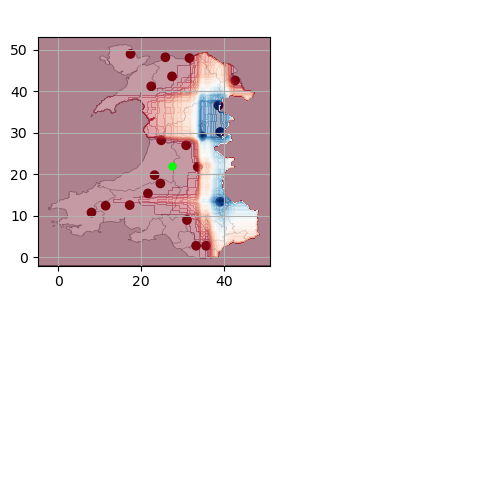

iteration  1
Accuracy is 0.48450470392916434
iteration  2
Accuracy is 0.7577937649880095
iteration  3
Accuracy is 0.7268339174813995
iteration  4
Accuracy is 0.7469101641763513
iteration  5
Accuracy is 0.7460800590296993
iteration  6
Accuracy is 0.7492775010760623
iteration  7
Accuracy is 0.8326569513619874
iteration  8
Accuracy is 0.8309352517985612
iteration  9
Accuracy is 0.8233413269384492
iteration  10
Accuracy is 0.835300989977249
iteration  11
Accuracy is 0.8397282174260592
iteration  12
Accuracy is 0.8434790629035234
iteration  13
Accuracy is 0.8619873332103548
iteration  14
Accuracy is 0.8557461722929349
iteration  15
Accuracy is 0.8603271229170509
iteration  16
Accuracy is 0.8443399126852364
iteration  17
Accuracy is 0.854916067146283
iteration  18
Accuracy is 0.8506425628727787
iteration  19
Accuracy is 0.8202053741622087
iteration  20
Accuracy is 0.8452622517370719
iteration  21
Accuracy is 0.853563303203591
experiment:  16


<IPython.core.display.Javascript object>


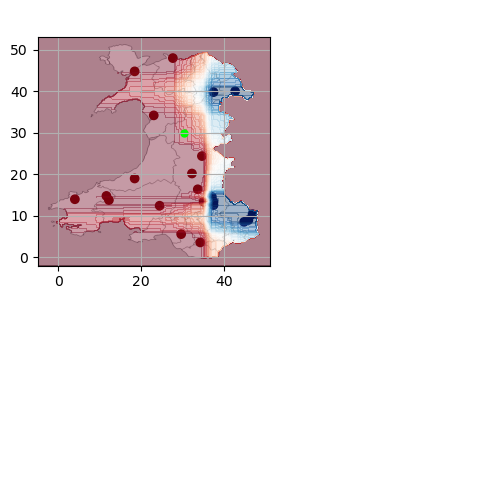

iteration  1
Accuracy is 0.6588882739961877
iteration  2
Accuracy is 0.6934144991698948
iteration  3
Accuracy is 0.7239439217856484
iteration  4
Accuracy is 0.7019307630818422
iteration  5
Accuracy is 0.7428826169833364
iteration  6
Accuracy is 0.7461415482998217
iteration  7
Accuracy is 0.7427596384430917
iteration  8
Accuracy is 0.7643423722560413
iteration  9
Accuracy is 0.7788845846399803
iteration  10
Accuracy is 0.7892762712906598
iteration  11
Accuracy is 0.8114431531697719
iteration  12
Accuracy is 0.8032035909733751
iteration  13
Accuracy is 0.8146405952161347
iteration  14
Accuracy is 0.8176535694521306
iteration  15
Accuracy is 0.8060320973990038
iteration  16
Accuracy is 0.7952099858574678
iteration  17
Accuracy is 0.8080304986779807
iteration  18
Accuracy is 0.8197442046362909
iteration  19
Accuracy is 0.8086146467441432
iteration  20
Accuracy is 0.8204820758777593
iteration  21
Accuracy is 0.8142409149603395
experiment:  17


<IPython.core.display.Javascript object>


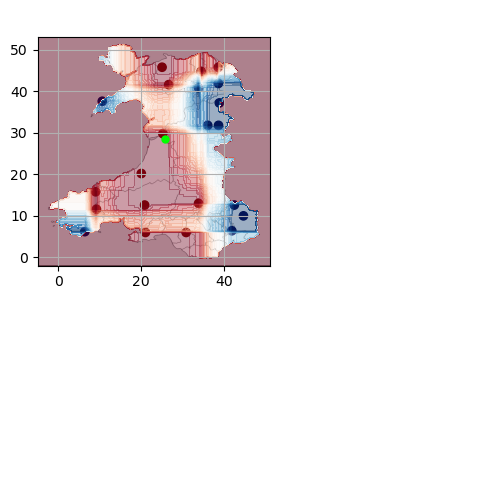

iteration  1
Accuracy is 0.3987271721084671
iteration  2
Accuracy is 0.40404599397405155
iteration  3
Accuracy is 0.5367705835331734
iteration  4
Accuracy is 0.5675459632294164
iteration  5
Accuracy is 0.7565639795855623
iteration  6
Accuracy is 0.8132878312734427
iteration  7
Accuracy is 0.830074402016848
iteration  8
Accuracy is 0.7743651232859866
iteration  9
Accuracy is 0.7893685051958433
iteration  10
Accuracy is 0.8089835823648773
iteration  11
Accuracy is 0.80046731845293
iteration  12
Accuracy is 0.8776670970915575
iteration  13
Accuracy is 0.8778823095369858
iteration  14
Accuracy is 0.8746541228555617
iteration  15
Accuracy is 0.8612494619688864
iteration  16
Accuracy is 0.8716104039845047
iteration  17
Accuracy is 0.8291828076000738
iteration  18
Accuracy is 0.9018631248847077
iteration  19
Accuracy is 0.910379388796655
iteration  20
Accuracy is 0.9037078029883785
iteration  21
Accuracy is 0.9066900325893131
experiment:  18


<IPython.core.display.Javascript object>


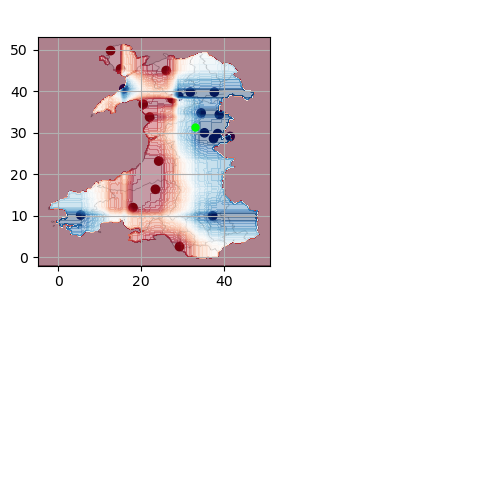

iteration  1
Accuracy is 0.4189878866137859
iteration  2
Accuracy is 0.40841173215273935
iteration  3
Accuracy is 0.4138842771936297
iteration  4
Accuracy is 0.7885691446842525
iteration  5
Accuracy is 0.8020967841111726
iteration  6
Accuracy is 0.8086146467441432
iteration  7
Accuracy is 0.8146405952161347
iteration  8
Accuracy is 0.8132878312734427
iteration  9
Accuracy is 0.8195597368259239
iteration  10
Accuracy is 0.8339789706696181
iteration  11
Accuracy is 0.8448010822111541
iteration  12
Accuracy is 0.7989915759699933
iteration  13
Accuracy is 0.7840189386951977
iteration  14
Accuracy is 0.8205435651478817
iteration  15
Accuracy is 0.8486134169587407
iteration  16
Accuracy is 0.8371456680809198
iteration  17
Accuracy is 0.8143946381356453
iteration  18
Accuracy is 0.7648957756871426
iteration  19
Accuracy is 0.7795609666113263
iteration  20
Accuracy is 0.7775318206972883
iteration  21
Accuracy is 0.769200024595708
experiment:  19


<IPython.core.display.Javascript object>


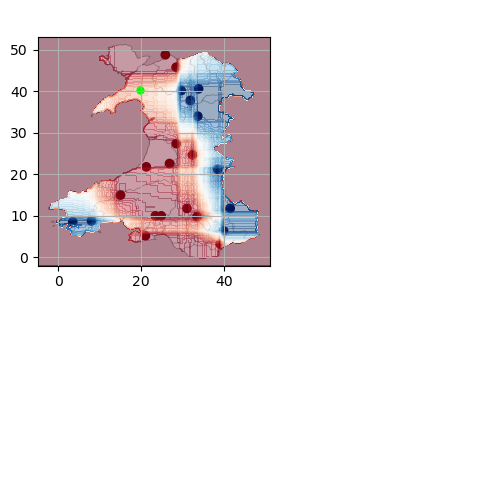

iteration  1
Accuracy is 0.5763696734919757
iteration  2
Accuracy is 0.5388612187173338
iteration  3
Accuracy is 0.529084424767878
iteration  4
Accuracy is 0.539414622148435
iteration  5
Accuracy is 0.6001660210293304
iteration  6
Accuracy is 0.5380926028408043
iteration  7
Accuracy is 0.7614831211953514
iteration  8
Accuracy is 0.8078152862325524
iteration  9
Accuracy is 0.7433437865092541
iteration  10
Accuracy is 0.7757486318637398
iteration  11
Accuracy is 0.7547193014818914
iteration  12
Accuracy is 0.8010514665190924
iteration  13
Accuracy is 0.8012359343294595
iteration  14
Accuracy is 0.8058168849535756
iteration  15
Accuracy is 0.8249400479616307
iteration  16
Accuracy is 0.8358236487732891
iteration  17
Accuracy is 0.8262005779991392
iteration  18
Accuracy is 0.8320113140257025
iteration  19
Accuracy is 0.8219270737256349
iteration  20
Accuracy is 0.8357621595031667
iteration  21
Accuracy is 0.8561458525487302
experiment:  20


<IPython.core.display.Javascript object>


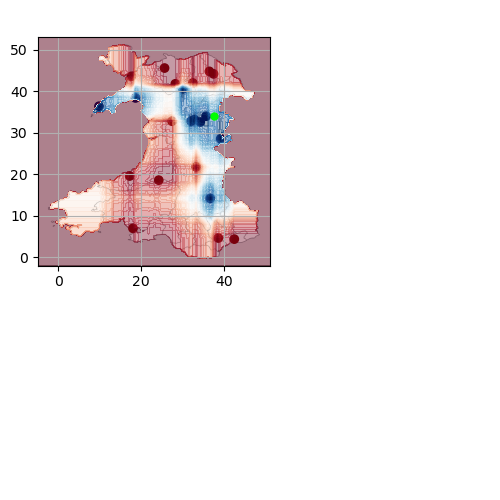

iteration  1
Accuracy is 0.648127651724774
iteration  2
Accuracy is 0.7594232306462523
iteration  3
Accuracy is 0.7081104347291398
iteration  4
Accuracy is 0.5920186927381172
iteration  5
Accuracy is 0.5881448687204083
iteration  6
Accuracy is 0.6005349566500645
iteration  7
Accuracy is 0.5908811412408534
iteration  8
Accuracy is 0.6763204820758778
iteration  9
Accuracy is 0.6752444198487364
iteration  10
Accuracy is 0.738578368074771
iteration  11
Accuracy is 0.7335362479247372
iteration  12
Accuracy is 0.7017770399065363
iteration  13
Accuracy is 0.7847568099366661
iteration  14
Accuracy is 0.7637582241898788
iteration  15
Accuracy is 0.7792535202607145
iteration  16
Accuracy is 0.783219578183607
iteration  17
Accuracy is 0.7867552112156428
iteration  18
Accuracy is 0.803511037323987
iteration  19
Accuracy is 0.7995757240361557
iteration  20
Accuracy is 0.8267539814302404
iteration  21
Accuracy is 0.8213736702945336


In [7]:
from random import randint
import time

valid_seeds = [27,12,15,21,25,36,37,41,45,48,50,51,52,53,54,57,61,63,64,71,75]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            hblauColor(landpoints[value],threshold_low1,threshold_high1,threshold_low2,threshold_high2)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], hblauColor(nextpoint,threshold_low1,threshold_high1,threshold_low2,threshold_high2)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 82.68 %
Improvement is = 17.86 %


In [9]:
Results

[[0.7836192584394023,
  0.7980692369181578,
  0.7814056447149972,
  0.6225788599889319,
  0.6454528684744512,
  0.7148127651724774,
  0.7752259730676997,
  0.7402078337330136,
  0.7732275717887229,
  0.7204697780237349,
  0.7561335546947058,
  0.7544425997663408,
  0.7837729816147082,
  0.7852179794625838,
  0.7846645760314825,
  0.7638812027301236,
  0.785586915083318,
  0.7775010760622272,
  0.7837729816147082,
  0.7769784172661871,
  0.777992990223206],
 [0.6406874500399681,
  0.7157965934944353,
  0.7212691385353256,
  0.7049129926827769,
  0.719485949701777,
  0.7241898788661378,
  0.7383939002644039,
  0.7590235503904569,
  0.788138719793396,
  0.77731660825186,
  0.7870011682961323,
  0.7933960523888581,
  0.7523519645821805,
  0.7670171555063642,
  0.7615138658304126,
  0.8003443399126853,
  0.8316116337699071,
  0.8268769599704852,
  0.8333640779683945,
  0.8364692861095738,
  0.8479677796224558],
 [0.39380803049867796,
  0.6623624177581012,
  0.5515587529976019,
  0.536370903

In [10]:
np.savetxt('hblauRandom', Results)

In [11]:
tst = np.loadtxt('hblauRandom')

<IPython.core.display.Javascript object>


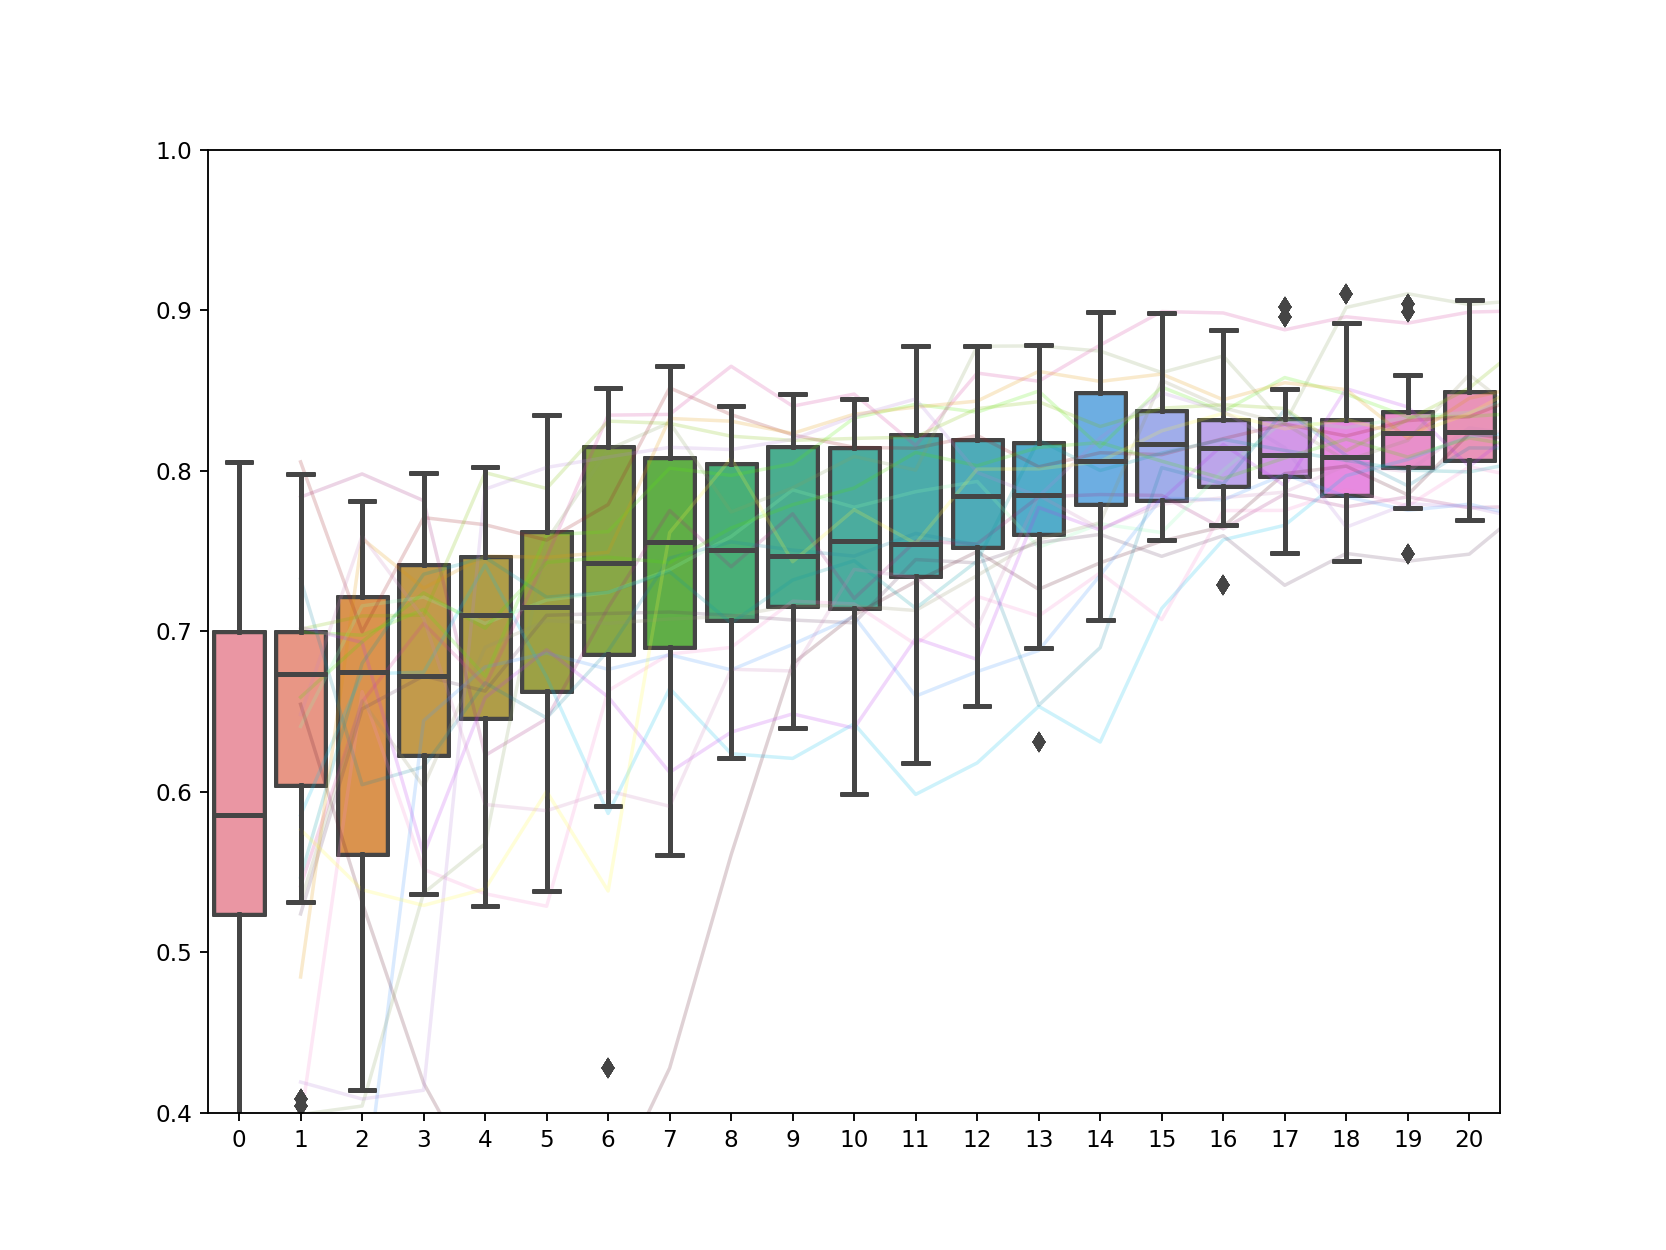

In [12]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns

# define a and b here
a = tst
b = []
for i in range(21):
    b.append(i+1)

# Helps pick a random color for each plot, used for readability
rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
ax.set(ylim=(0.4, 1))

for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr, alpha = 0.2)
    sns.boxplot(data=tst)